# NFT sales forecasting - Predicting the price of NFTs using visual features. 
What we want is to give an image to the model, and it will give us an evaluation of the price it could be sold. 

The evaluation shouldn't relie only on the market data but also on the image itself. Thus we will use a CNN model of AlexNet architecture to train the relationship between the image and the price, and an RNN model to compute the time series of prices along dates. 

In [1]:
import numpy as np
from numpy import newaxis
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras import models
from keras.models import Model
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input
from keras.layers import InputSpec, Input, Conv2D, concatenate, Bidirectional,CuDNNLSTM,Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from dataclasses import dataclass

import base64
from PIL import Image
import io
from io import BytesIO
import cv2

from sklearn.decomposition import PCA
from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
punks_train = pd.read_csv("drive/My Drive/opencampus/ML with TF - NFT sales forecasting/datasets/punks_train_historical.csv")
punks_train = punks_train.sort_values(['date']).reset_index(drop=True)
punks_train=punks_train[['date','token_id','btc_usd','img']]
punks_train.head()

,date,token_id,btc_usd,img
0,2017-11-09,2690,7143.580078,b'iVBORw0KGgoAAAANSUhEUgAAAVAAAAFQCAYAAADp6CbZ...
1,2017-11-09,5623,7143.580078,b'iVBORw0KGgoAAAANSUhEUgAAAVAAAAFQCAYAAADp6CbZ...
2,2017-11-12,9965,5950.069824,b'iVBORw0KGgoAAAANSUhEUgAAAVAAAAFQCAYAAADp6CbZ...
3,2017-11-13,7750,6559.490234,b'iVBORw0KGgoAAAANSUhEUgAAAVAAAAFQCAYAAADp6CbZ...
4,2017-11-13,7464,6559.490234,b'iVBORw0KGgoAAAANSUhEUgAAAVAAAAFQCAYAAADp6CbZ...


In [4]:
punks_test = pd.read_csv("drive/My Drive/opencampus/ML with TF - NFT sales forecasting/datasets/punks_test_historical.csv")
punks_test = punks_test.sort_values(['date']).reset_index(drop=True)
punks_test = punks_test[['date','token_id','btc_usd','img']]
punks_test.head()

,date,token_id,btc_usd,img
0,2021-07-31,5879,41626.195312,b'iVBORw0KGgoAAAANSUhEUgAAAVAAAAFQCAYAAADp6CbZ...
1,2021-07-31,7244,41626.195312,b'iVBORw0KGgoAAAANSUhEUgAAAVAAAAFQCAYAAADp6CbZ...
2,2021-07-31,773,41626.195312,b'iVBORw0KGgoAAAANSUhEUgAAAVAAAAFQCAYAAADp6CbZ...
3,2021-07-31,782,41626.195312,b'iVBORw0KGgoAAAANSUhEUgAAAVAAAAFQCAYAAADp6CbZ...
4,2021-07-31,9353,41626.195312,b'iVBORw0KGgoAAAANSUhEUgAAAVAAAAFQCAYAAADp6CbZ...


In [5]:
# Converting date column to Date-Time dtype
punks_train['date'] = pd.to_datetime(punks_train['date'])
punks_test['date'] = pd.to_datetime(punks_test['date'])
# Converting token_id column to object dtype
punks_train['token_id'] = punks_train['token_id'].astype(str)
punks_test['token_id'] = punks_test['token_id'].astype(str)

In [6]:
punks_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14346 entries, 0 to 14345
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      14346 non-null  datetime64[ns]
 1   token_id  14346 non-null  object        
 2   btc_usd   14346 non-null  float64       
 3   img       14346 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 448.4+ KB


# Data selection to match our challenge

Predicting the price of a single item is not really significant: the most sold items only have 15 sales records. We will make predictions at the collection scale. 

To compute a time series at the collection size, we will need to get a date + a price (+ a visual feature)

As the mean of images doesn't make a lot of sense, we will input the median sale price (+ image) for each day. tdates aren't continuous in our dataset since nfts of the cryptopunks collection aren't sold everyday. instead of generating fake data to fill missing dates, we will just compute the time series as if it was continuous which for this case doesn't seems disturbing. 

In [7]:
# select median sale for each date in dataframe
dates = punks_train['date'].unique()
median_sales = []
token_ids = []
imgs=[]

for date in dates:
  day_sales = punks_train.loc[punks_train['date']== date]
  median_sale = day_sales['btc_usd'].median()
  median_sales.append(median_sale)
  token = day_sales['token_id'].loc[(day_sales['date']== date) & (day_sales['btc_usd'] == median_sale)].values[0]
  token_ids.append(token)
  img = day_sales['img'].loc[(day_sales['date'] == date) & (day_sales['btc_usd'] == median_sale) & (day_sales['token_id'] == token)].values[0]
  imgs.append(img)

median_daily_train = pd.DataFrame(list(zip(dates, token_ids, median_sales, imgs)), columns=['date', 'token_id', 'btc_usd', 'img'])
median_daily_train.head()

,date,token_id,btc_usd,img
0,2017-11-09,2690,7143.580078,b'iVBORw0KGgoAAAANSUhEUgAAAVAAAAFQCAYAAADp6CbZ...
1,2017-11-12,9965,5950.069824,b'iVBORw0KGgoAAAANSUhEUgAAAVAAAAFQCAYAAADp6CbZ...
2,2017-11-13,7750,6559.490234,b'iVBORw0KGgoAAAANSUhEUgAAAVAAAAFQCAYAAADp6CbZ...
3,2017-11-14,2795,6635.750000,b'iVBORw0KGgoAAAANSUhEUgAAAVAAAAFQCAYAAADp6CbZ...
4,2017-11-15,5670,7315.540039,b'iVBORw0KGgoAAAANSUhEUgAAAVAAAAFQCAYAAADp6CbZ...


In [8]:
# same for test
dates = punks_test['date'].unique()
median_sales = []
token_ids = []
imgs=[]

for date in dates:
  day_sales = punks_test.loc[punks_test['date']== date]
  median_sale = day_sales['btc_usd'].median()
  median_sales.append(median_sale)
  token = day_sales['token_id'].loc[(day_sales['date']== date) & (day_sales['btc_usd'] == median_sale)].values[0]
  token_ids.append(token)
  img = day_sales['img'].loc[(day_sales['date'] == date) & (day_sales['btc_usd'] == median_sale) & (day_sales['token_id'] == token)].values[0]
  imgs.append(img)

median_daily_test = pd.DataFrame(list(zip(dates, token_ids, median_sales, imgs)), columns=['date', 'token_id', 'btc_usd', 'img'])
median_daily_test.head()

,date,token_id,btc_usd,img
0,2021-07-31,5879,41626.195312,b'iVBORw0KGgoAAAANSUhEUgAAAVAAAAFQCAYAAADp6CbZ...
1,2021-08-01,8918,39974.894531,b'iVBORw0KGgoAAAANSUhEUgAAAVAAAAFQCAYAAADp6CbZ...
2,2021-08-02,622,39201.945312,b'iVBORw0KGgoAAAANSUhEUgAAAVAAAAFQCAYAAADp6CbZ...
3,2021-08-03,2723,38152.980469,b'iVBORw0KGgoAAAANSUhEUgAAAVAAAAFQCAYAAADp6CbZ...
4,2021-08-04,7192,39747.503906,b'iVBORw0KGgoAAAANSUhEUgAAAVAAAAFQCAYAAADp6CbZ...


# Visual feature extraction

Our first attempts to predict the value of NFTs from image's feature extraction isn't showing any good result. The image only is not enough to forecast the price of an item and thus other factors than the visual features must be influencing the price of an NFT sale.

In this notebook, we will start by extracting visual features from each median sale's image with the hypothesis in mind that it could help increase the price prediction's accuracy.

We will process the images in a CNN, reduce dimensionality of the output and store it for further use.

# Is VGG16 CNN model learning better than Alexnet?

Alexnet's not learning nothing, try with the pre-trained model VGG16, which has a pre-process feature, if it can achieve better results.

In [9]:
#upload pre-trained model
pretrained = VGG16(weights='imagenet', include_top=False, input_shape=(64,64,3))

vgg = models.Sequential()
vgg.add(pretrained)
# add the output layers to match our needs
vgg.add(Flatten())
vgg.add(Dense(units=4096, input_shape=(None,4096), activation='relu'))
vgg.add(Dense(4096, input_shape=(None,4096), activation='relu'))

vgg.compile(
    loss='mean_squared_error',
    optimizer=tf.optimizers.Adam(lr=1e-04),
    metrics=['mae']    
)

#visualise model architecture
pretrained.summary()
vgg.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


(336, 336, 4)
(336, 336, 3)
(64, 64, 3)
(1, 64, 64, 3)
(1, 4096)


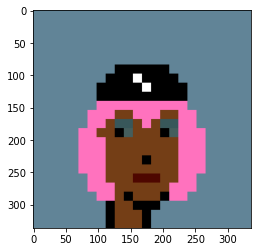

In [10]:
img_data = base64.b64decode(median_daily_train.img[0][1:])
img = Image.open(io.BytesIO(img_data))
img = np.array(img)
print(img.shape)
plt.imshow(img)
img = img[:,:,:3]
print(img.shape)
img = cv2.resize(img,(64,64))
print(img.shape)
img = img.reshape(1,64,64,3)
print(img.shape)
#pass the reshaped array in the preprocess input for vgg16 model
img = preprocess_input(img)
# pass the image through the predict method
features = vgg.predict(img, use_multiprocessing=True)
print(features.shape)

In [11]:
# define X-y axes at the same time
X_train = []
y_train =[]
X_test = []
y_test =[]

# loop through each image in the dataset
for index, row in median_daily_train.iterrows():
  b64_img = median_daily_train.img.loc[index][1:]
  img_data = base64.b64decode(b64_img)
  img = Image.open(io.BytesIO(img_data))
  img = np.array(img)
  img = img[:,:,:3]
  img = cv2.resize(img,(64,64))
  img = img.reshape(1,64,64,3)
  #pass the reshaped array in the preprocess input for vgg16 model
  img = preprocess_input(img)
  X_train.append((img))
  label_array = tf.convert_to_tensor(median_daily_train.btc_usd.loc[index], dtype=tf.float32)
  y_train.append(label_array)

# same for test set
for index, row in median_daily_test.iterrows():
  b64_img = median_daily_train.img.loc[index][1:]
  img_data = base64.b64decode(b64_img)
  img = Image.open(io.BytesIO(img_data))
  img = np.array(img)
  img = img[:,:,:3]
  img = cv2.resize(img,(64,64))
  img = img.reshape(1,64,64,3)
  #pass the reshaped array in the preprocess input for vgg16 model
  img = preprocess_input(img)
  X_test.append((img))
  label_array = tf.convert_to_tensor(median_daily_test.btc_usd.loc[index], dtype=tf.float32)
  y_test.append(label_array)

# convert to array
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

1000
1000
69
69
(1000, 1, 64, 64, 3)
(1000,)
(69, 1, 64, 64, 3)
(69,)


In [12]:
X_train = X_train.reshape(1000, 64, 64, 3)
print(X_train.shape)
X_test = X_test.reshape(69, 64, 64, 3)
print(X_test.shape)

(1000, 64, 64, 3)
(69, 64, 64, 3)


In [13]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = (train_ds.batch(batch_size=8,drop_remainder=True))

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_ds = (test_ds.batch(batch_size=8,drop_remainder=True))

train_ds_size = tf.data.experimental.cardinality(train_ds).numpy()
test_ds_size = tf.data.experimental.cardinality(test_ds).numpy()
print("Training data size:", train_ds_size)
print("Test data size:", test_ds_size)

Training data size: 125
Test data size: 8


In [14]:
# fit vgg by running over the dataset multiple epochs. test prediction each epoch
history = vgg.fit(
    train_ds,
    epochs = 50,
    validation_data=test_ds,
    validation_freq=1
)

Epoch 1/50
125/125 [==============================] - 237s 2s/step - loss: 152931264.0000 - mae: 7179.0859 - val_loss: 697641472.0000 - val_mae: 24866.0020
Epoch 2/50
125/125 [==============================] - 212s 2s/step - loss: 91047544.0000 - mae: 5059.4663 - val_loss: 385247328.0000 - val_mae: 15375.5000
Epoch 3/50
125/125 [==============================] - 211s 2s/step - loss: 86743992.0000 - mae: 5206.0137 - val_loss: 392864480.0000 - val_mae: 16239.2275
Epoch 4/50
125/125 [==============================] - 210s 2s/step - loss: 83546328.0000 - mae: 5081.1890 - val_loss: 369498144.0000 - val_mae: 15506.3535
Epoch 5/50
125/125 [==============================] - 211s 2s/step - loss: 81761304.0000 - mae: 5052.7021 - val_loss: 384017088.0000 - val_mae: 16261.5098
Epoch 6/50
125/125 [==============================] - 215s 2s/step - loss: 79265328.0000 - mae: 4941.3398 - val_loss: 393536416.0000 - val_mae: 16771.5312
Epoch 7/50
125/125 [==============================] - 211s 2s/step - 

In [15]:
vgg.history.history.keys()

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])

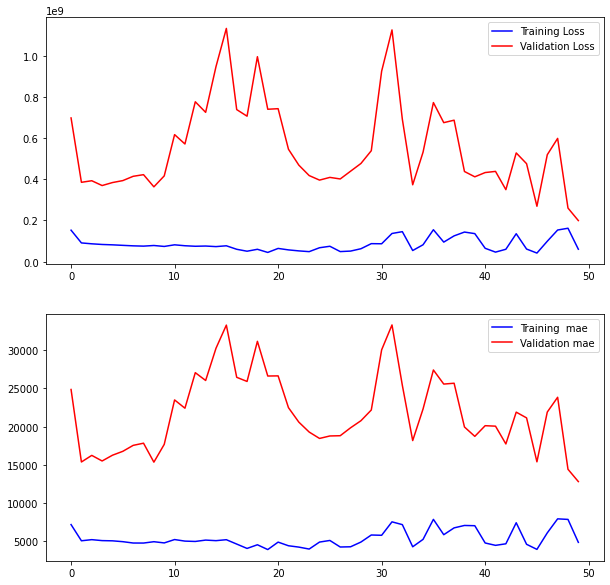

In [16]:
f,ax=plt.subplots(2,1,figsize=(10,10)) 

#Assigning the first subplot to graph training loss and validation loss
ax[0].plot(vgg.history.history['loss'],color='b',label='Training Loss')
ax[0].plot(vgg.history.history['val_loss'],color='r',label='Validation Loss')
ax[0].legend(loc='upper right')

#Plotting the training accuracy and validation accuracy
ax[1].plot(vgg.history.history['mae'],color='b',label='Training  mae')
ax[1].plot(vgg.history.history['val_mae'],color='r',label='Validation mae')

plt.legend()

# process all images with the trained model and save the outputs for further input in final model

In [17]:
# extract the features from all images and store it in a dictionary with index as keys
data_train = {}
data_test = {}

# loop through each image in the dataset
for index, row in median_daily_train.iterrows():
  # pass the image through the predict method
  features = vgg.predict(img, use_multiprocessing=True)
  #save the feature extraction in the dictionary
  data_train[index] = features

# same for test set
for index, row in median_daily_test.iterrows():
  # pass the image through the predict method
  features = vgg.predict(img, use_multiprocessing=True)
  data_test[index] = features

In [18]:
# get a list of the extracted features
outputCNN_train = np.array(list(data_train.values()))
outputCNN_test = np.array(list(data_test.values()))
print(outputCNN_train.shape)
print(outputCNN_test.shape)

# reshape so that there are samples of 4096 vectors
#outputCNN_train = outputCNN_train.reshape(-1,4096)
#outputCNN_test = outputCNN_test.reshape(-1,4096)
#print(outputCNN_train.shape)
#print(outputCNN_test.shape)

(1000, 1, 4096)
(69, 1, 4096)


In [19]:
# save CNN output
with open('outputCNN_train.txt', 'w') as f:
    for item in outputCNN_train:
        f.write("%s\n" % item)

files.download('outputCNN_train.txt')

with open('outputCNN_test.txt', 'w') as f:
    for item in outputCNN_test:
        f.write("%s\n" % item)

files.download('outputCNN_test.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Process historical sales data in an RNN model

Dimensions of an RNN model should be of 3: 

- number of feature variables (in our case: time + prices), 
- time steps, 
- batch size.

In [20]:
# function to write the time series
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [21]:
# creating time series from df
times_train = []
series_train = []
times_test = []
series_test = []

step=0
for index, row in median_daily_train.iterrows():
  times_train.append(step)
  series_train.append(float(row.btc_usd))
  step += 1

for index, row in median_daily_test.iterrows():
  times_test.append(step)
  series_test.append(float(row.btc_usd))
  step += 1

beware that this is considering dates are continuous which is not true in our dataset

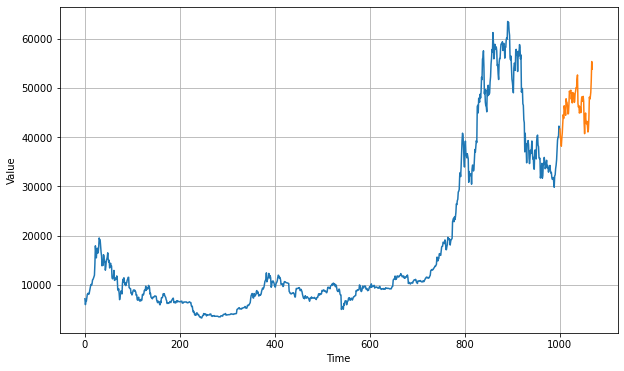

In [22]:
# Test your function and save all "global" variables within the G class (G stands for global)
@dataclass
class train:
    TIME = np.array(times_train)
    SERIES = np.array(series_train)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 32
    BATCH_SIZE = 256
    SHUFFLE_BUFFER_SIZE = 1000

class test:
    TIME = np.array(times_test)
    SERIES = np.array(series_test)
    SPLIT_TIME = 2500
    WINDOW_SIZE = 32
    BATCH_SIZE = 256
    SHUFFLE_BUFFER_SIZE = 1000

plt.figure(figsize=(10, 6))
plot_series(train.TIME, train.SERIES)
plot_series(test.TIME, test.SERIES)
plt.show()

In [23]:
time_train = train.TIME
series_train = train.SERIES
time_test = test.TIME
series_test = test.SERIES
print(time_train.shape)
print(series_train.shape)
print(time_test.shape)
print(series_test.shape)

(1000,)
(1000,)
(69,)
(69,)


In [24]:
def windowed_dataset(series, window_size=train.WINDOW_SIZE, batch_size=train.BATCH_SIZE, shuffle_buffer=train.SHUFFLE_BUFFER_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


# Apply the transformation to the datasets
train_set = windowed_dataset(series_train, window_size=train.WINDOW_SIZE, batch_size=train.BATCH_SIZE, shuffle_buffer=train.SHUFFLE_BUFFER_SIZE)
test_set = windowed_dataset(series_test, window_size=test.WINDOW_SIZE, batch_size=test.BATCH_SIZE, shuffle_buffer=test.SHUFFLE_BUFFER_SIZE)

In [25]:
# defining an RNN model architecture
rnn = tf.keras.models.Sequential([
                                  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),input_shape=[None]),
                                  tf.keras.layers.BatchNormalization(),
                                  tf.keras.layers.SimpleRNN(40, return_sequences=True),
                                  tf.keras.layers.BatchNormalization(),
                                  tf.keras.layers.SimpleRNN(40),
                                  tf.keras.layers.BatchNormalization(),
                                  tf.keras.layers.Dense(1),
                                  #tf.keras.layers.Lambda(lambda x: x * 100.0)
                                  ])

rnn.compile(loss='mean_squared_error',
            optimizer=tf.optimizers.Adam(lr=1e-1),
            metrics=["mae"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [26]:
# Train it
history = rnn.fit(train_set, epochs=50)

Epoch 1/50
4/4 [==============================] - 3s 170ms/step - loss: 528006048.0000 - mae: 16794.5820
Epoch 2/50
4/4 [==============================] - 0s 35ms/step - loss: 527335968.0000 - mae: 16787.9355
Epoch 3/50
4/4 [==============================] - 0s 31ms/step - loss: 526211680.0000 - mae: 16771.9590
Epoch 4/50
4/4 [==============================] - 0s 38ms/step - loss: 524393056.0000 - mae: 16743.0254
Epoch 5/50
4/4 [==============================] - 0s 31ms/step - loss: 521793920.0000 - mae: 16698.5977
Epoch 6/50
4/4 [==============================] - 0s 33ms/step - loss: 518141760.0000 - mae: 16636.1797
Epoch 7/50
4/4 [==============================] - 0s 36ms/step - loss: 513329888.0000 - mae: 16553.3203
Epoch 8/50
4/4 [==============================] - 0s 34ms/step - loss: 507338432.0000 - mae: 16447.7012
Epoch 9/50
4/4 [==============================] - 0s 33ms/step - loss: 500039616.0000 - mae: 16317.7168
Epoch 10/50
4/4 [==============================] - 0s 36ms/step

In [27]:
# compute model evaluation
def compute_metrics(true_series, forecast):
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    return mse, mae

In [28]:
print(len(series_test))
dataset = tf.data.Dataset.from_tensor_slices(series_test)
dataset = dataset.window(1, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda w: w.batch(test.WINDOW_SIZE))
dataset = dataset.batch(32).prefetch(1)
rnn_forecast = rnn.predict(dataset).squeeze()
print(len(rnn_forecast))
print(rnn_forecast)

69
69
[39844.02  38763.59  38196.723 37039.543 38653.098 39250.105 40421.293
 40828.02  40577.613 41961.973 41549.184 41555.19  40766.812 42219.934
 42143.465 42135.26  41805.098 40905.613 40971.613 42067.656 42274.668
 42266.355 42274.38  42277.81  42213.355 42267.582 42116.434 42269.62
 42266.28  42264.57  42136.605 42154.168 42264.99  42274.48  42283.918
 42282.973 42303.805 42317.55  42089.48  41848.035 41971.223 41027.105
 41262.13  41834.52  41082.984 42142.754 42242.29  42219.215 42168.19
 42246.824 42167.23  40426.934 39126.543 40539.668 41034.85  40426.113
 40398.69  40487.664 40230.19  39376.043 39796.8   40576.24  42239.41
 42213.777 42243.383 42270.684 42300.707 42402.598 42344.19 ]


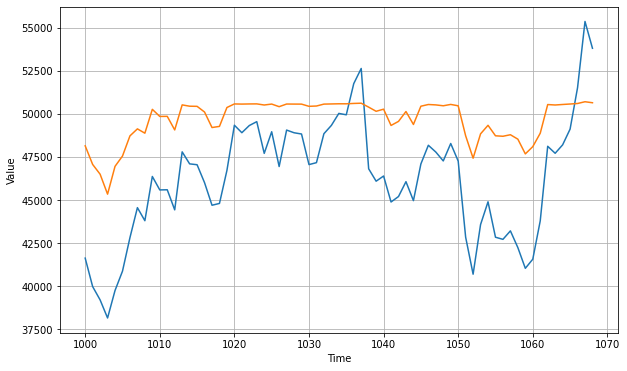

In [29]:
# Plot the forecast
plt.figure(figsize=(10, 6))
plot_series(time_test, series_test)
plot_series(time_test, rnn_forecast+8300)

In [30]:
mse, mae = compute_metrics(series_test, rnn_forecast)
print(f"mse: {mse:.2f}, mae: {mae:.2f} for forecast")

mse: 29615914.00, mae: 4865.52 for forecast


In [31]:
# compute the predictions and store it into a dictionary
data_train = {}
data_test = {}

trainset = tf.data.Dataset.from_tensor_slices(series_train)
trainset = trainset.window(1, shift=1, drop_remainder=True)
trainset = trainset.flat_map(lambda w: w.batch(test.WINDOW_SIZE))
trainset = trainset.batch(32).prefetch(1)
pred = rnn.predict(trainset).squeeze()
data_train[index] = pred

testset = tf.data.Dataset.from_tensor_slices(series_test)
testset = testset.window(1, shift=1, drop_remainder=True)
testset = testset.flat_map(lambda w: w.batch(test.WINDOW_SIZE))
testset = testset.batch(32).prefetch(1)
pred = rnn.predict(testset).squeeze()
data_test[index] = pred

In [32]:
# get a list of the extracted features
outputRNN_train = np.array(list(data_train.values()))
outputRNN_test = np.array(list(data_test.values()))
print(outputRNN_train.shape)
print(outputRNN_test.shape)

# reshape
outputRNN_train = outputRNN_train.reshape(1000,1) # 1000*1 value
outputRNN_test = outputRNN_test.reshape(69,1) # 69*1 value
print(outputRNN_train.shape)
print(outputRNN_test.shape)

# add a 3rd dimension to fit the model input
outputRNN_train = outputRNN_train[:,newaxis,:] # we want 3d arrays
outputRNN_test = outputRNN_test[:,newaxis,:] # we want 3d arrays
print(outputRNN_train.shape)
print(outputRNN_test.shape)

(1, 1000)
(1, 69)
(1000, 1)
(69, 1)
(1000, 1, 1)
(69, 1, 1)


In [33]:
# save RNN output
with open('outputRNN_train.txt', 'w') as f:
    for item in outputRNN_train:
        f.write("%s\n" % item)

files.download('outputRNN_train.txt')

with open('outputRNN_test.txt', 'w') as f:
    for item in outputRNN_test:
        f.write("%s\n" % item)

files.download('outputRNN_test.txt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Final model - compute both CNN and RNN outputs together

Since we are trying to predict the price over time, it will be a time series, but instead of time only we will have an X which will concatenate all dependent variables, and a target variable y which will be the price of median sale. 

A similar process could be used to compute as much input variables as we want, and indeed we should add some relevant predictors to improve our model performance, such as bitcoin rate at date (and other coins as well), stock market prices, social trends on nfts (google search data, twitter, reddit...) community engagement data for our collection (discord activity?)...

In [34]:
print(outputCNN_train.shape)
print(outputCNN_test.shape)
print(outputRNN_train.shape)
print(outputRNN_test.shape)

X_train = concatenate([outputCNN_train, outputRNN_train]) # merge the two outputs. 
X_test = concatenate([outputCNN_test, outputRNN_test])
y_train = np.array(series_train)
y_test = np.array(series_test)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1000, 1, 4096)
(69, 1, 4096)
(1000, 1, 1)
(69, 1, 1)
(1000, 1, 4097)
(69, 1, 4097)
(1000,)
(69,)


In [35]:
# using a CNN+LSTM to compute the prediction on combined input
final = tf.keras.models.Sequential([
                                    tf.keras.layers.Conv1D(filters=64,kernel_size=3,strides=1,padding="causal",activation="relu",input_shape=[1, 4097]), # adapt to our input
                                    tf.keras.layers.LSTM(64, return_sequences=True),
                                    tf.keras.layers.LSTM(64),
                                    tf.keras.layers.Dense(32, activation="relu"),
                                    tf.keras.layers.Dense(16, activation="relu"),
                                    tf.keras.layers.Dense(1) # fit to predict the tuple of values
                                    ])

final.compile(loss='mean_squared_error',
              optimizer=tf.optimizers.Adam(learning_rate=1e-1),
              metrics=["mae"])

final.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             786688    
                                                                 
 lstm (LSTM)                 (None, 1, 64)             33024     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 16)                528       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 855,361
Trainable params: 855,361
Non-tr

In [36]:
# Train the final model
history = final.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=1,
    shuffle=False, # no shuffle for time series
    validation_split=0.1
)

Epoch 1/50
900/900 [==============================] - 12s 10ms/step - loss: 5832826.5000 - mae: 1387.6965 - val_loss: 114050056.0000 - val_mae: 10055.6182
Epoch 2/50
900/900 [==============================] - 8s 9ms/step - loss: 27213432.0000 - mae: 2915.7241 - val_loss: 161589520.0000 - val_mae: 11725.6592
Epoch 3/50
900/900 [==============================] - 8s 9ms/step - loss: 15543565.0000 - mae: 1747.3607 - val_loss: 260452208.0000 - val_mae: 14580.0537
Epoch 4/50
900/900 [==============================] - 8s 9ms/step - loss: 353309280.0000 - mae: 13329.8096 - val_loss: 1386939904.0000 - val_mae: 36281.9727
Epoch 5/50
900/900 [==============================] - 8s 9ms/step - loss: 219196544.0000 - mae: 8534.2168 - val_loss: 799144704.0000 - val_mae: 26992.3594
Epoch 6/50
900/900 [==============================] - 8s 9ms/step - loss: 173328048.0000 - mae: 7575.0029 - val_loss: 546427136.0000 - val_mae: 21814.4258
Epoch 7/50
900/900 [==============================] - 8s 9ms/step - lo

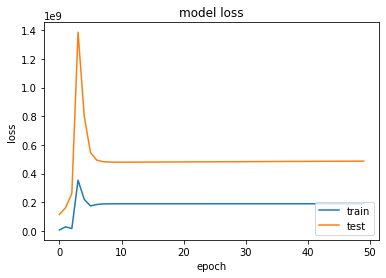

In [37]:
# plot the final model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

In [38]:
# predictions on test set
y_pred = final.predict(X_test)

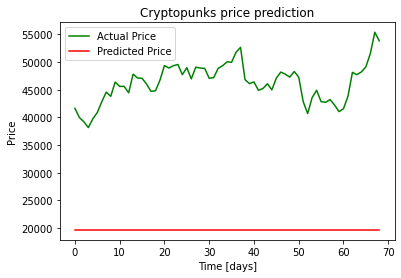

In [39]:
# plot predictions compared to true values
plt.plot(y_test, label="Actual Price", color='green')
plt.plot(y_pred, label="Predicted Price", color='red')
 
plt.title('Cryptopunks price prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show()

In [40]:
# get all three mae / mse on the same plot to compare methods


### we can see that images + historical sales data achieves a best prediction performance than each of them taken individually. 

### this is encourageing to grow our forecasting model in a multivariate one inputting more variables.